<a href="https://colab.research.google.com/github/Nathan-Roll1/PSST/blob/main/PSST_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [ ]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [ ]:
!pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.seterr(all="ignore")

import os
from scipy import signal
import pickle
from tqdm import tqdm

import scienceplots
plt.style.use(['science','nature'])

# Plots

In [ ]:
os.mkdir('/content/figures')

In [ ]:
trscrpt_path = '/content/drive/Shareddrives/Rezonator Data/SBCSAE/'
trscrpt_paths = sorted([trscrpt_path+x for x in os.listdir(trscrpt_path) if '.cha' in x.lower()])

In [ ]:
lens = []

for path in tqdm(trscrpt_paths):

  with open(path,'r') as f:
    a = f.read()

  lines = [x.split('\t',1)[1] for x in a.split('\n') if ('\x15' in x)]

  for line in lines:
    start_ms = int(line.split('\x15',1)[1].split('_',1)[0])
    end_ms = int(line.split('_')[-1].split('\x15',1)[0])
    if (end_ms > start_ms) and (end_ms - start_ms < 40000):
      lens.append(round((end_ms-start_ms)/1000,3))

lens = np.array(lens)

100%|██████████| 60/60 [00:15<00:00,  3.95it/s]


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Ling Thesis/medium_all_data.csv')

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
def plot_most_freq(s, location='start', relative=False):
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> ')) for x in df[s]]))
  if location=='start':
    iu_starts = [x.split(' ')[0].lower() for x in ius]
  elif location == 'end':
    iu_starts = [x.split(' ')[-1].lower() for x in ius]
  d = {j:len([x for x in iu_starts if x==j]) for j in list(set(iu_starts))}
  if relative:
    d = {k:d[k]/np.sum(list(d.values())) for k in sorted(d.keys())}
  else:
    d = {k:d[k] for k in sorted(d.keys())}

  most_freq_iu_start_words = pd.DataFrame(d, index = ['freq']).T.sort_values(by='freq', ascending=False).iloc[:10]
  plt.bar(most_freq_iu_start_words.index, most_freq_iu_start_words['freq'])

  n = f'{s}_{location}_rel_freq'

  # plt.title('\\textbf{'+n.replace('_', ' ').title()+'}')
  plt.savefig(f'figures/{n}.png', dpi=300)
  plt.show()

In [ ]:
def load_metrics():
  with open('/content/drive/Shareddrives/Ling Thesis/metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

  #replace low pass 150hz filter (nan) to baseline accuracy/metrics (all negative preds)
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> '), dtype=object) for x in df['actual_transcript']]), dtype=object)

  tn = np.sum([len(x.split(' ')) for x in ius])
  fn = len(ius) + 2 #total number of boundaries +start bound + end bound
  baseline_accuracy = tn/(tn+fn)

  metrics['150_low']['accuracy'] = baseline_accuracy
  metrics['150_low']['precision'] = 0
  metrics['150_low']['recall'] = 0
  metrics['150_low']['f1'] = 0

  return metrics

In [ ]:
plt.rcParams["figure.figsize"] = (4,3)

<ipython-input-20-4828c9190782>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> ')) for x in df[s]]))


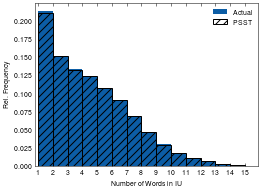

In [ ]:
for s in ['actual_transcript', 'model_generated']:
  
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> ')) for x in df[s]]))
  ius_lens = [len(x.split(' ')) for x in ius]
  ius_lens = np.array(ius_lens)

  if s == 'actual_transcript':
    plt.hist(ius_lens, bins=max(ius_lens)-min(ius_lens), weights=np.zeros_like(ius_lens) + 1. / ius_lens.size, label='Actual')
  else:
    plt.hist(ius_lens, bins=max(ius_lens)-min(ius_lens), fill=None, hatch='///', weights=np.zeros_like(ius_lens) + 1. / ius_lens.size, label = 'PSST')

plt.xticks(np.arange(min(ius_lens), max(ius_lens)+1, 1.0))
plt.xlim([0.8, 15.9])
plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=False, right=False)

plt.legend()
plt.xlabel('Number of Words in IU')
plt.ylabel('Rel. Frequency')
# plt.title('\\textbf{IU Length Distribution (words)}')
plt.savefig('figures/rel_freq_words.png', dpi=300)
plt.show()

<ipython-input-21-c64258baa0b4>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> ')) for x in df[s]]))


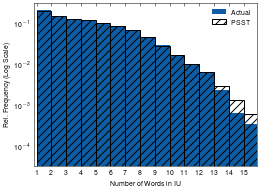

In [ ]:
for s in ['actual_transcript', 'model_generated']:
  
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> ')) for x in df[s]]))
  ius_lens = [len(x.split(' ')) for x in ius]
  ius_lens = np.array(ius_lens)

  if s == 'actual_transcript':
    plt.hist(ius_lens, bins=max(ius_lens)-min(ius_lens), log=True, weights=np.zeros_like(ius_lens) + 1. / ius_lens.size, label='Actual')
  else:
    plt.hist(ius_lens, bins=max(ius_lens)-min(ius_lens), log=True, fill=None, hatch='///', weights=np.zeros_like(ius_lens) + 1. / ius_lens.size, label = 'PSST')

plt.xticks(np.arange(min(ius_lens), max(ius_lens)+1, 1.0))
plt.xlim([0.8, 15.9])
plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=False, right=False)

plt.legend()
plt.xlabel('Number of Words in IU')
plt.ylabel('Rel. Frequency (Log Scale)')
# plt.title('\\textbf{IU Length Distribution (words)}')
plt.savefig('figures/rel_freq_words_log.png', dpi=300)
plt.show()

In [ ]:
df['num_units_gen'] = [len(x.split(' <|IU_Boundary|> ')) for x in df['model_generated']]
df['num_units_actual'] = [len(x.split(' <|IU_Boundary|> ')) for x in df['actual_transcript']]

df['audio_len_per_gen'] = df['audio_len']/df['num_units_gen']
df['audio_len_per_actual'] = df['audio_len']/df['num_units_actual']

d = {}

for s in ['gen','actual']:
  d[s] = []

  for n, l in zip(df[f'num_units_{s}'], df[f'audio_len_per_{s}']):
    for i in range(n):
      d[s].append(l)

  d[s] = np.array(d[s])

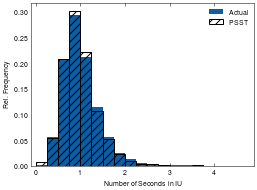

In [ ]:
plt.hist(d['actual'], bins=80, weights=np.zeros_like(d['actual']) + 1. / d['actual'].size, label='Actual', range=(0, 20))
plt.hist(d['gen'], bins=80, fill=None, hatch='///', weights=np.zeros_like(ius_lens) + 1. / ius_lens.size, label = 'PSST', range=(0, 20))
plt.legend()
plt.xlabel('Number of Seconds in IU')
plt.ylabel('Rel. Frequency')

plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=False, right=False)
plt.xlim([-0.1, 4.9])

# plt.title('\\textbf{IU Length Distribution (seconds)}')
plt.savefig('figures/rel_freq_seconds.png', dpi=300)

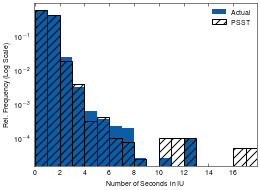

In [ ]:
plt.hist(d['actual'], bins=20, log=True, weights=np.zeros_like(d['actual']) + 1. / d['actual'].size, label='Actual', range=(0, 20))
plt.hist(d['gen'], bins=20, fill=None, hatch='///', log=True, weights=np.zeros_like(ius_lens) + 1. / ius_lens.size, label = 'PSST', range=(0, 20))
plt.legend()
plt.xlabel('Number of Seconds in IU')
plt.ylabel('Rel. Frequency (Log Scale)')

plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=False, right=False)
plt.xlim([-0.1, 17.9])

# plt.title('\\textbf{IU Length Distribution (seconds)}')
plt.savefig('figures/rel_freq_seconds_log.jpg', dpi=300)

In [ ]:
plt.rcParams["figure.figsize"] = (6.5,3)

<ipython-input-26-4dd42ec2cf01>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> ')) for x in df[s]]))


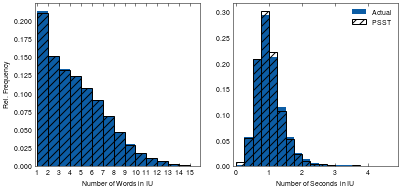

In [ ]:
plt.subplot(1, 2, 1)
for s in ['actual_transcript', 'model_generated']:
  
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> ')) for x in df[s]]))
  ius_lens = [len(x.split(' ')) for x in ius]
  ius_lens = np.array(ius_lens)

  if s == 'actual_transcript':
    plt.hist(ius_lens, bins=max(ius_lens)-min(ius_lens), weights=np.zeros_like(ius_lens) + 1. / ius_lens.size, label='Actual')
  else:
    plt.hist(ius_lens, bins=max(ius_lens)-min(ius_lens), fill=None, hatch='///', weights=np.zeros_like(ius_lens) + 1. / ius_lens.size, label = 'PSST')

plt.xticks(np.arange(min(ius_lens), max(ius_lens)+1, 1.0))
plt.xlim([0.8, 15.9])
plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=False, right=False)

# plt.legend()
plt.xlabel('Number of Words in IU')
plt.ylabel('Rel. Frequency')
# plt.title('\\textbf{IU Length Distribution (words)}')
# plt.savefig('figures/rel_freq_words.png', dpi=300)
# plt.show()

#######################################################

df['num_units_gen'] = [len(x.split(' <|IU_Boundary|> ')) for x in df['model_generated']]
df['num_units_actual'] = [len(x.split(' <|IU_Boundary|> ')) for x in df['actual_transcript']]

df['audio_len_per_gen'] = df['audio_len']/df['num_units_gen']
df['audio_len_per_actual'] = df['audio_len']/df['num_units_actual']

d = {}

for s in ['gen','actual']:
  d[s] = []

  for n, l in zip(df[f'num_units_{s}'], df[f'audio_len_per_{s}']):
    for i in range(n):
      d[s].append(l)

  d[s] = np.array(d[s])

#######################################################  
plt.subplot(1, 2, 2)
plt.hist(d['actual'], bins=80, weights=np.zeros_like(d['actual']) + 1. / d['actual'].size, label='Actual', range=(0, 20))
plt.hist(d['gen'], bins=80, fill=None, hatch='///', weights=np.zeros_like(ius_lens) + 1. / ius_lens.size, label = 'PSST', range=(0, 20))
plt.legend()
plt.xlabel('Number of Seconds in IU')
# plt.ylabel('Rel. Frequency')

plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=False, right=False)
plt.xlim([-0.1, 4.9])

# plt.title('\\textbf{IU Length Distribution (seconds)}')
plt.savefig('figures/rel_freq_combined.png', dpi=300)

In [ ]:
plt.rcParams["figure.figsize"] = (4,3)

<ipython-input-17-12a7643b2aeb>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> ')) for x in df[s]]))


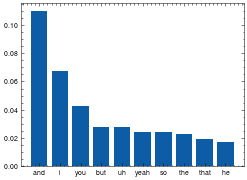

In [ ]:
plot_most_freq('actual_transcript', location='start', relative=True)

<ipython-input-17-12a7643b2aeb>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> ')) for x in df[s]]))


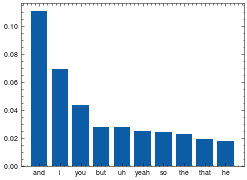

In [ ]:
plot_most_freq('model_generated', location='start', relative=True)

<ipython-input-17-12a7643b2aeb>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> ')) for x in df[s]]))


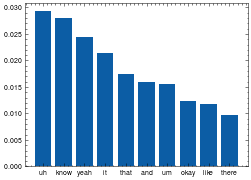

In [ ]:
plot_most_freq('actual_transcript', location = 'end', relative=True)

<ipython-input-17-12a7643b2aeb>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> ')) for x in df[s]]))


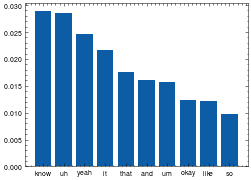

In [ ]:
plot_most_freq('model_generated', location = 'end', relative=True)

In [ ]:
plt.rcParams["figure.figsize"] = (6.5,3)

In [ ]:
plt.rcParams.update({'font.size': 50})

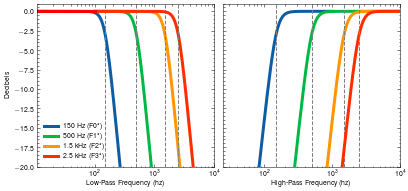

In [ ]:
plt.subplot(1, 2, 1)
for frq in [(150, 0.15, '150 Hz (F0*)'),(500, 0.4, '500 Hz (F1*)'),(1500, 0.7, '1.5 kHz (F2*)'),(2500, 1, '2.5 kHz (F3*)')]:
  b, a = signal.butter(4, frq[0], 'low', analog=True)
  w, h = signal.freqs(b, a)
  plt.semilogx(w, 20 * np.log10(abs(h)), label = f'{frq[2]}', linewidth=3)
  plt.axvline(frq[0], linestyle='--', color='grey') # cutoff frequency

# plt.title('\\textbf{Low Pass Filters}')
plt.xlabel('Low-Pass Frequency (hz)')
plt.ylabel('Decibels')
plt.plot([10,100],[0,0], color = 'red', linewidth=3)
plt.xlim([11, 10e3])
plt.ylim([-20, 1])
plt.legend()

# plt.savefig('figures/low_pass_filters.png', dpi=300)
# plt.show()

plt.subplot(1, 2, 2)
for frq in [(150, 0.15, 'F0'),(500, 0.4, 'F1'),(1500, 0.7, 'F2'),(2500, 1, 'F3')]:
  b, a = signal.butter(4, frq[0], 'high', analog=True)
  w, h = signal.freqs(b, a)
  # plt.semilogx(w, 20 * np.log10(abs(h)), color = 'black', alpha=frq[1], label = f'{frq[0]} hz ({frq[2]})', linewidth=3)
  # plt.axvline(frq[0], alpha=frq[1], color = 'black', linestyle='--') # cutoff frequency
  plt.semilogx(w, 20 * np.log10(abs(h)), label = f'{frq[0]} hz ({frq[2]})', linewidth=3)
  plt.axvline(frq[0], linestyle='--', color='grey')

# plt.title('\\textbf{High Pass Filters}')
plt.xlabel('High-Pass Frequency (hz)')
plt.xlim([25, 10e3])
plt.ylim([-20, 1])
plt.tick_params(axis='y', labelleft=False)
# plt.legend()

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('figures/filters.png', dpi=300)
plt.show()

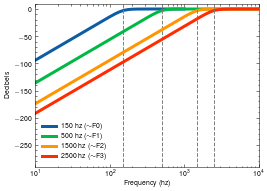

In [ ]:
plt.rcParams["figure.figsize"] = (4,3)

for frq in [(150, 0.15, '$\sim$F0'),(500, 0.4, '$\sim$F1'),(1500, 0.7, '$\sim$F2'),(2500, 1, '$\sim$F3')]:
  b, a = signal.butter(4, frq[0], 'high', analog=True)
  w, h = signal.freqs(b, a)
  # plt.semilogx(w, 20 * np.log10(abs(h)), color = 'black', alpha=frq[1], label = f'{frq[0]} hz ({frq[2]})', linewidth=3)
  # plt.axvline(frq[0], alpha=frq[1], color = 'black', linestyle='--') # cutoff frequency
  plt.semilogx(w, 20 * np.log10(abs(h)), label = f'{frq[0]} hz ({frq[2]})', linewidth=3)
  plt.axvline(frq[0], linestyle='--', color='grey')

# plt.title('\\textbf{High Pass Filters}')
plt.xlabel('Frequency (hz)')
plt.ylabel('Decibels')
plt.xlim([10, 10e3])
plt.ylim([-290, 10])
plt.legend()

plt.savefig('figures/high_pass_filters.png', dpi=300)
plt.show()

In [ ]:
metrics = load_metrics()

<ipython-input-18-e5fedc261c20>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ius = np.concatenate(np.array([np.array(x.split(' <|IU_Boundary|> '), dtype=object) for x in df['actual_transcript']]), dtype=object)


In [ ]:
metric_df = pd.DataFrame(metrics).T

In [ ]:
metric_df.sort_values(by='accuracy',ascending=False, inplace=True)

In [ ]:
metric_df.index = [x.replace('_',' ').replace('baseline (','').replace(')','') for x in metric_df.index]
# metric_df = metric_df.drop('150 low')

In [ ]:
plt.rcParams["figure.figsize"] = (4,3)

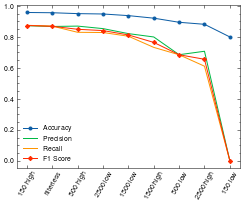

In [ ]:
plt.plot(metric_df.index, metric_df['accuracy'], marker='o', label='Accuracy')
plt.plot(metric_df.index, metric_df['precision'], label='Precision')
plt.plot(metric_df.index, metric_df['recall'], label='Recall')
plt.plot(metric_df.index, metric_df['f1'], marker='D', label='F1 Score')
plt.legend()
plt.xticks(rotation=60)
plt.tick_params(axis='x', which='minor', bottom=False, top=False)
# plt.title('\\textbf{Performance with Frequency Reductions}')
plt.savefig('figures/filter_metrics.png', dpi=300)

In [ ]:
high_pass = metric_df.loc[['150 high','500 high','1500 high','2500 high']]
high_pass.index = ['150 Hz','500 Hz','1500 Hz','2500 Hz']

low_pass = metric_df.loc[['150 low','500 low','1500 low','2500 low']]
low_pass.index = ['150 Hz','500 Hz','1500 Hz','2500 Hz']

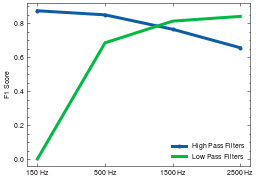

In [ ]:
plt.plot(high_pass.index, high_pass['f1'], label='High Pass Filters', marker='o', linewidth=3)
plt.plot(low_pass.index, low_pass['f1'], label='Low Pass Filters', linewidth=3)
plt.ylabel('F1 Score')
plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.legend()
plt.savefig('figures/filter_hpvslp.png', dpi=300)

In [ ]:
for col in metric_df.columns:
  metric_df[col] = [round(float(x), 3) for x in metric_df[col]]

In [ ]:
metric_df.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  accuracy &  precision &  recall &     f1 \\\\\n\\midrule\n150 high   &     0.958 &      0.873 &   0.875 &  0.874 \\\\\nfilterless &     0.957 &      0.868 &   0.870 &  0.869 \\\\\n500 high   &     0.951 &      0.870 &   0.830 &  0.850 \\\\\n2500 low   &     0.949 &      0.854 &   0.829 &  0.841 \\\\\n1500 low   &     0.938 &      0.822 &   0.805 &  0.813 \\\\\n1500 high  &     0.922 &      0.800 &   0.733 &  0.765 \\\\\n500 low    &     0.895 &      0.685 &   0.685 &  0.685 \\\\\n2500 high  &     0.882 &      0.708 &   0.611 &  0.656 \\\\\n150 low    &     0.800 &      0.000 &   0.000 &  0.000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
with open('/content/drive/Shareddrives/Ling Thesis/f1_acc_len.pkl', 'rb') as f:
  d = pickle.load(f)

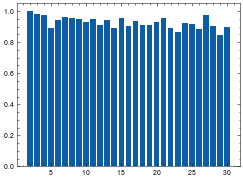

In [ ]:
plt.bar(list(d['f1_len'].keys())[:30], list(d['f1_len'].values())[:30])
plt.savefig('figures/f1_len.png', dpi=300)

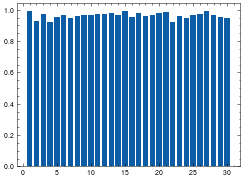

In [ ]:
plt.bar(list(d['acc_len'].keys())[:30], list(d['acc_len'].values())[:30])
plt.savefig('figures/acc_len.png', dpi=300)